In [1]:
import gymnasium as gym
import numpy as np

In [2]:
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False)

In [3]:
state_space = env.observation_space
print(f"There are {state_space.n} possible states.")

action_space = env.action_space
print(f"There are {action_space.n} possible actions.")
# env.observation_space.sample()

There are 64 possible states.
There are 4 possible actions.


In [4]:
action_space.sample()

np.int64(3)

In [5]:
import random
from typing import Literal
import math

def initialize_q_table(state_space: gym.Space, action_space: gym.Space):
    return np.zeros((state_space.n, action_space.n))

def greedy_policy(q_table: np.ndarray, state: np.int64) -> np.int64:
    return np.argmax(q_table[state])

def epsilon_greedy_policy(q_table: np.ndarray, action_space: gym.Space, state: np.int64, epsilon: float) -> np.int64:
    # With probability epsilon, we take a random action (exploration)
    if random.random() < epsilon:
        return action_space.sample()
    
    # Otherwise, greedy policy
    return greedy_policy(q_table, state)

def epsilon_decay(step: int, total_steps: int, decay_type: Literal["linear", "cosine"], max_eps = 1.0, min_eps = 0.05) -> float:
    if decay_type == "linear":
        return max_eps - (step + 1) * (max_eps - min_eps) / total_steps
    elif decay_type == "cosine":
        # Adapted from PyTorch's CosineAnnealingLR
        coeff = 0.5 * (1.0 + math.cos(math.pi * step / total_steps))
        return min_eps + coeff * (max_eps - min_eps)
    else:
        raise Exception(f"Unknown decay_type={decay_type}. Expected 'linear' or 'cosine'.")


In [6]:
# Training hyperparameters
n_episodes = 10000
lr = 0.7

n_steps = 99  # Max steps per episode
gamma = 0.5  # Discounting rate for future reward

max_eps = 1.0  # Exploration probability at start
min_eps = 0.05  # Minimum exploration probability

# Evaluation parameters
n_eval_episodes = 100  # total number of test episodes

In [7]:
def evaluate_agent(env: gym.Env, n_eval_episodes: int, n_eval_steps: int, q_table: np.ndarray):
    episode_rewards = []
    for _ in range(n_eval_episodes):
        state, info = env.reset()

        truncated = False
        terminated = False
        total_rewards_ep = 0

        for _ in range(n_eval_steps):
            # Use greedy policy for evaluation.
            action = greedy_policy(q_table, state)
            new_state, reward, terminated, truncated, info = env.step(action)
            total_rewards_ep += reward

            if terminated or truncated:
                break

            state = new_state

        episode_rewards.append(total_rewards_ep)

    # Mean / average reward over episodes
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    return mean_reward, std_reward


def train(
    env: gym.Env,
    n_episodes: int,
    n_steps: int,
    max_eps: float,
    min_eps: float,
    gamma: float,
    lr: float,
    n_eval_episodes: int,
):
    # Global step number, used for epsilon decay
    global_step = 0

    # Initialize Q-table
    q_table = initialize_q_table(env.observation_space, env.action_space)

    for _ in range(n_episodes):
        state, info = env.reset()

        for _ in range(n_steps):
            global_step += 1

            # Determine action via epsilon-greedy policy
            eps = epsilon_decay(global_step, n_episodes * n_steps, "linear", max_eps, min_eps)
            action = epsilon_greedy_policy(q_table, env.action_space, state, eps)
            
            # Take action At and observe Rt+1 and St+1
            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, terminated, truncated, info = env.step(action)
            predicted_reward = q_table[state][action]
            expected_reward = reward + gamma * q_table[new_state][greedy_policy(q_table, new_state)]
            
            # Update q_table
            q_table[state][action] = predicted_reward + lr * (expected_reward - predicted_reward)

            if terminated or truncated:
                break

            # Print some evaluation stats...
            if global_step > 0 and global_step % 1000 == 0:
                mean_eval, std_eval = evaluate_agent(env, n_eval_episodes, n_steps, q_table)
                print(f"Step {global_step:5d} | Mean reward: {mean_eval:.4f} | StdDev reward {std_eval:.4f}")

            state = new_state
    
    return q_table

In [8]:
test = train(
    env,
    n_episodes,
    n_steps,
    max_eps,
    min_eps,
    gamma,
    lr,
    n_eval_episodes,
)

Step  2000 | Mean reward: 0.0000 | StdDev reward 0.0000
Step  3000 | Mean reward: 0.0000 | StdDev reward 0.0000
Step  4000 | Mean reward: 0.0000 | StdDev reward 0.0000
Step  6000 | Mean reward: 1.0000 | StdDev reward 0.0000
Step  7000 | Mean reward: 1.0000 | StdDev reward 0.0000
Step  8000 | Mean reward: 1.0000 | StdDev reward 0.0000
Step  9000 | Mean reward: 1.0000 | StdDev reward 0.0000
Step 10000 | Mean reward: 1.0000 | StdDev reward 0.0000
Step 11000 | Mean reward: 1.0000 | StdDev reward 0.0000
Step 12000 | Mean reward: 1.0000 | StdDev reward 0.0000
Step 13000 | Mean reward: 1.0000 | StdDev reward 0.0000
Step 14000 | Mean reward: 1.0000 | StdDev reward 0.0000
Step 15000 | Mean reward: 1.0000 | StdDev reward 0.0000
Step 16000 | Mean reward: 1.0000 | StdDev reward 0.0000
Step 17000 | Mean reward: 1.0000 | StdDev reward 0.0000
Step 18000 | Mean reward: 1.0000 | StdDev reward 0.0000
Step 19000 | Mean reward: 1.0000 | StdDev reward 0.0000
Step 20000 | Mean reward: 1.0000 | StdDev reward

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

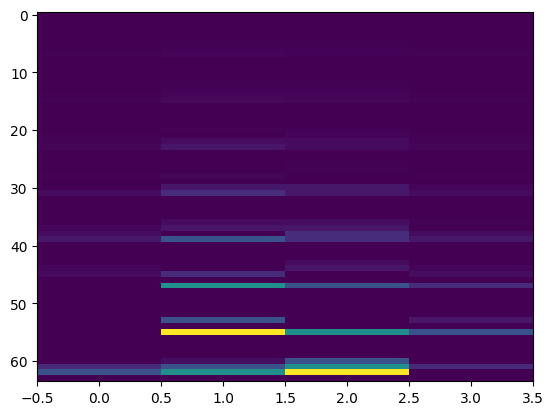

In [10]:
plt.imshow(test, aspect='auto')